Logger init :  (5, 0)
DQN(
  (embedder_item): Embedding(5, 10)
  (embedder_client): Embedding(5, 10)
  (dense1): Linear(in_features=20, out_features=128, bias=True)
  (dense2): Linear(in_features=128, out_features=5, bias=True)
)


/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3152: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


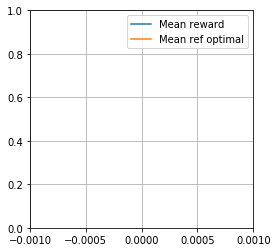

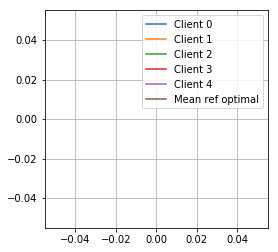

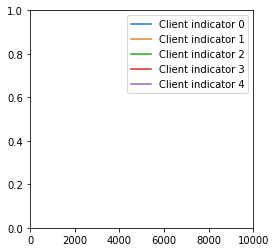

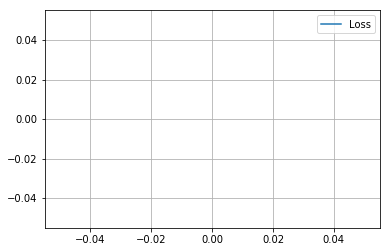

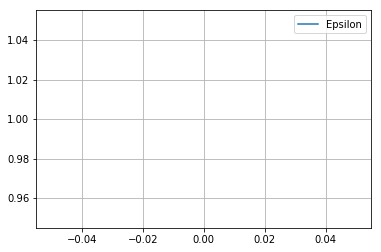

Episode 0 with reward : 8 and epsilon


IndexError: too many indices for array

In [103]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from IPython.display import clear_output
from Environment.BanditEnvironment_stationary import BanditEnvironment as env_generator
from Tools import Logger
from collections import deque

n_feature_item = 3
n_feature_client = 3
range_price = 10
range_color = 5
n_client = 5
n_item = 5
size_embedding_client = 10
size_embedding_item = 10
hidden_layer_size = 128
hidden_layer_2_size = 128
learning_rate = 5e-4
log_delay = 100
batch_size = 32
target_update = 50
epsilon_decay = 10
GAMMA = 0.99
class DQN(nn.Module) :
    def __init__(self, gamma) :
        super(DQN, self).__init__()
        self.create_model()
        self.gamma = gamma



    def create_model(self) :
        
        self.embedder_item = nn.Embedding(n_item, size_embedding_item)
        self.embedder_client = nn.Embedding(n_client, size_embedding_client)
        self.dense1 = nn.Linear(size_embedding_item + size_embedding_client, hidden_layer_size)
        self.dense2 = nn.Linear(hidden_layer_size, n_item)

    def forward(self, x) :
        x = np.array(x)
        if x.shape[0] < 2 : # Not batch
            client_ID = torch.tensor(x[0], dtype = torch.long)
            items_lists = x[1]
            items_list_ID = torch.tensor([item.get_id for item in items_lists])
            print(items_lists_ID.shape)
            embeds_client = self.embedder_client(client_ID)  # .view((1, -1))
            embeds_items = self.embedder_item(items_list_ID)  # .view((1, -1))
            concatenattion = torch.cat((embeds_client, embeds_items), dim = -1)
            out_1 = torch.relu(self.dense1(concatenattion))
            return self.dense2(out_1)
        else:
            client_ID =  torch.from_numpy(np.array(x[:, 0], dtype = int))
            items_lists = x[:, 1]
            concat_items_list_ID = []
            for subitems_lists in items_lists:
                items_list_ID = [item.get_id for item in subitems_lists]
                concat_items_list_ID.append(items_list_ID)
            concat_items_list_ID = torch.from_numpy(np.array(concat_items_list_ID, dtype = int))
            embeds_client = self.embedder_client(client_ID)
            embeds_items = self.embedder_item(concat_items_list_ID)
            embeds_client = embeds_client.reshape((batch_size, 1, embeds_client.shape[1]))
            embeds_client = embeds_client * \
                            torch.from_numpy(np.ones((batch_size, n_item, embeds_client.shape[2]))).float()
            concatenattion = torch.cat((embeds_client, embeds_items), dim = -1)
            out_1 = torch.relu(self.dense1(concatenattion))
            return self.dense2(out_1)

    def remember(self, memory, state, action, next_state, reward, done):
        memory.append((state, action, next_state, reward, done))

    def sample(self, batch_size, memory):
        indices = np.random.choice(len(memory), batch_size, replace = False)
        states, actions, next_states, rewards, dones = zip(*[memory[idx] for idx in indices])
        return np.array(states), torch.Tensor(actions), np.array(next_states), np.array(rewards), np.array(dones)


    def choose_action(self, state, epsilon):

        coin_toss = np.random.random()
        if coin_toss < epsilon :
            return np.random.randint(n_item)
        else :
            return torch.argmax(self(state)[0]).item()


def replay(modele, target, memory, optimizer):
    states, actions, next_states, rewards, dones = modele.sample(batch_size, memory)
    prediction = torch.Tensor((1 - dones) * (rewards + modele.gamma * np.amax(target(next_states).detach().max(1)[0].numpy(), axis = 1)))
    prediction = prediction.view(-1, 1)
    real_value = modele(states)[:, 0, :]
    actions = actions.view(-1, 1)
    real_value = torch.Tensor(real_value).gather(1, actions.long())
    loss = F.mse_loss(real_value, prediction.float())
    optimizer.zero_grad()        
    loss.backward()
    optimizer.step()

memory = deque(maxlen = 10000)


class Runner() :
    def __init__(self, env, n_episode = 10000) :
        self.model = DQN(gamma = GAMMA)
        self.target = DQN(gamma = GAMMA)
        self.target.load_state_dict(self.model.state_dict())
        self.target.eval()
        #  self.model.cuda()
        self.env = env
        self.optimizer = optim.Adam(self.model.parameters(), lr = learning_rate)
        self.memory = []
        self.gamma = GAMMA
        self.log_delay = log_delay
        self.n_episode = n_episode
        self.batch_size = batch_size
        self.epsilon = np.finfo(np.float32).eps.item()
        self.logger = Logger.Logger(n_client, env)
        self.memory_loss = []
        self.epsilon_explo = 1.0
        self.epsilon_origin = 1.0


    def run(self) :
        print(self.model)
        epsilon_log = []
        cumulator = []
        ep_reward = 0
        last_reward = 0
        ep_reward_cumul = []
        mean_delta = []
        mean_log = []
        delay = 100
        for i_episode in range(self.n_episode) :
            client_id, items = self.env.reset()
            ep_reward_cumul.append(ep_reward)
            mean_delta.append(np.mean(cumulator))
            mean_log.append(np.mean(ep_reward_cumul))
            self.epsilon_explo = max(self.epsilon_origin - self.epsilon_origin * i_episode / epsilon_decay, 0.02)
            epsilon_log.append(self.epsilon_explo)
            if i_episode % self.log_delay == 0 :
            #    clear_output(True)
                self.logger.plot()
                plt.plot(self.memory_loss, label = "Loss")
                plt.grid()
                plt.legend()
                plt.show()
                plt.plot(epsilon_log, label = "Epsilon")
                plt.grid()
                plt.legend()
                plt.show()
            ep_reward = 0
            for t in range(delay) :  # Collect trajectoire
                # state = [client.get_properties[1], list_item, client_id]
                state = [client_id, items]
                action = self.model.choose_action(epsilon = self.epsilon_explo, state = state)
                client_id_next, items, reward = env.step_mono_recommendation(action)
                if reward > 0 :
                    delta = t + i_episode * delay - last_reward
                    cumulator.append(delta)
                    last_reward = t + i_episode * delay
                ep_reward += reward
                self.logger.add_reward_client(reward, client_id)
                next_state = [client_id_next, items]
                self.model.remember(memory = memory, state = state, next_state = next_state,\
                                    action = action, done = not(t < (delay - 1)), reward = reward)
                client_id = client_id_next
                if t % target_update == 0:
                    self.target.load_state_dict(self.model.state_dict())
            replay(modele = self.model, target = self.target, optimizer = self.optimizer, memory = memory)
            if i_episode % self.log_delay == 0 :
                print("Episode {} with reward : {} and epsilon".format(i_episode, ep_reward, self.epsilon))


if __name__ == '__main__' :
    env = env_generator(n_client = n_client, n_item = n_item, nb_color = range_color, range_price = range_price)

    runner = Runner(env)
    runner.run()

# TODO :
# Si un utilisateur a eut une bonne recommendation sa "satisfaction augmente" donc plus de chance d'achat, bonus en % sur chance d'achat
# Essayer https://arxiv.org/pdf/1810.12027.pdf

In [54]:
first = torch.from_numpy(np.ones((32, 5, 10)))
second = torch.from_numpy(np.ones((32, 10)))
first.shape, second.shape

(torch.Size([32, 5, 10]), torch.Size([32, 10]))

In [59]:
torch.cat((first, second), dim = 1)

RuntimeError: invalid argument 0: Tensors must have same number of dimensions: got 3 and 2 at /Users/soumith/code/builder/wheel/pytorch-src/aten/src/TH/generic/THTensorMath.cpp:3607

In [76]:
third = torch.from_numpy(np.ones((32, 10)).reshape((32, 1, 10))) * np.ones((32, 5, 10))
third.shape

TypeError: mul() received an invalid combination of arguments - got (numpy.ndarray), but expected one of:
 * (Tensor other)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!)
 * (Number other)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!)


In [74]:
torch.cat((first, third), dim = -1).shape

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 2. Got 5 and 1 in dimension 1 at /Users/soumith/code/builder/wheel/pytorch-src/aten/src/TH/generic/THTensorMath.cpp:3616

In [79]:
t = np.ones((32, 10)).reshape((32, 1, 10)) * np.ones((32, 5, 10))
t.shape

(32, 5, 10)

In [80]:
third = torch.from_numpy(t)
third.shape

torch.Size([32, 5, 10])

In [81]:
torch.cat((first, third), dim = -1).shape

torch.Size([32, 5, 20])

In [83]:
np.array([1, 2, 3]) * np.ones((3, 1))

array([[1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.]])

In [84]:
third.reshape((32, 50))

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], dtype=torch.float64)